# Spam Message Classification using Deep Learning

Natural language processing (NLP) for classifying SMS-messages as spam or not spam, based on the SMS contents.

## Install the Required Libraries

In [1]:
!pip3 install -q --upgrade numpy==1.19.2 pandas==1.1.2 matplotlib==3.3.2 scikit-learn==0.23.2 keras==2.4.0

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from collections import Counter

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Load the Dataset

In [3]:
sms_messages = pd.read_csv('../data/spam.csv', encoding='latin1')
sms_messages = sms_messages.iloc[:, [0, 1]]
sms_messages.columns = ["label", "message"]
sms_messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
sms_messages.shape

(5572, 2)

## Exploratory Data Analysis

### Label Count

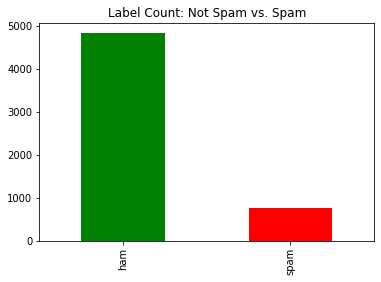

In [5]:
label_count = pd.value_counts(sms_messages["label"], sort=True)
label_count.plot(kind = "bar", color = ["green", "red"])
plt.title("Label Count: Not Spam vs. Spam")
plt.show()

### Message Uniqueness

In [6]:
sms_messages.groupby("label").describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

### Feature Engineering: Message Length

In [7]:
sms_messages["length"] = sms_messages["message"].apply(len)
sms_messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Compare Message Length by Label

Text(0.5, 0, 'Message Length')

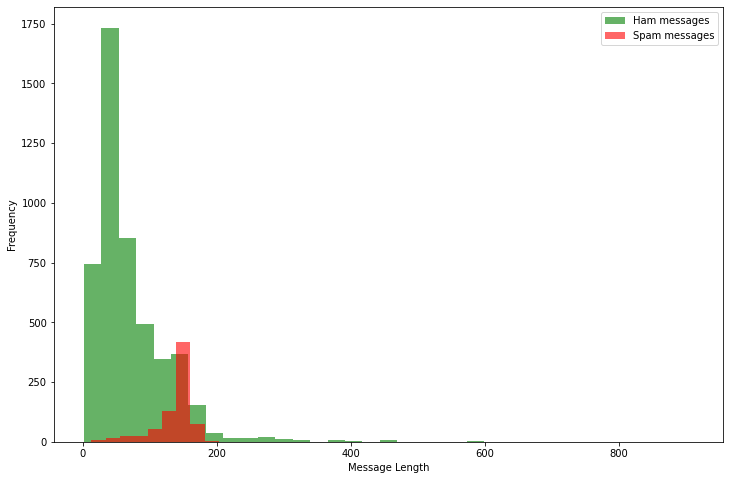

In [8]:
plt.figure(figsize=(12, 8))

sms_messages[sms_messages.label=="ham"].length.plot(
    bins=35, kind="hist", color="green", label="Ham messages", alpha=0.6)
sms_messages[sms_messages.label=="spam"].length.plot(
    kind="hist", color="red", label="Spam messages", alpha=0.6)

plt.legend()
plt.xlabel("Message Length")

### Most Common Words

In [9]:
common_ham = Counter(" ".join(sms_messages[sms_messages["label"] == "ham"]["message"]).split()).most_common(20)
df_common_ham = pd.DataFrame.from_dict(common_ham)
df_common_ham = df_common_ham.rename(columns={0: "Word", 1: "Count"})

common_spam = Counter(" ".join(sms_messages[sms_messages["label"] == "spam"]["message"]).split()).most_common(20)
df_common_spam = pd.DataFrame.from_dict(common_spam)
df_common_spam = df_common_spam.rename(columns={0: "Word", 1: "Count"})

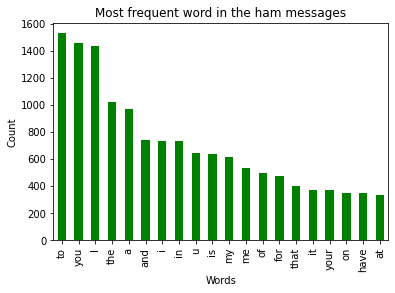

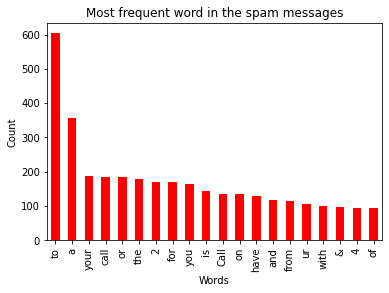

In [10]:
df_common_ham.plot.bar(legend = False, color = "green")
y_pos = np.arange(len(df_common_ham["Word"]))
plt.xticks(y_pos, df_common_ham["Word"])
plt.title("Most frequent word in the ham messages")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

df_common_spam.plot.bar(legend = False, color = "red")
y_pos = np.arange(len(df_common_spam["Word"]))
plt.xticks(y_pos, df_common_spam["Word"])
plt.title("Most frequent word in the spam messages")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

## Build the Model

### Preprocessing

In [12]:
vocabular_size = 400
oov_token = "<OOV>"
max_length = 250
embedding_dimension = 16
number_of_epochs = 50

In [13]:
column_encoding = ({"ham": 0, "spam": 1})
sms_messages = sms_messages.replace(column_encoding)
sms_messages.head()

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [14]:
X = sms_messages["message"]
Y = sms_messages["label"]

In [15]:
tokenizer = Tokenizer(num_words = vocabular_size, oov_token = oov_token)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
print(X)

[[51, 1, 1, 1, 1, 1, 65, 9, 1, 90, 122, 350, 1, 148, 1, 1, 68, 59, 1, 145], [47, 337, 1, 1, 7, 1], [48, 1, 9, 20, 5, 1, 1, 3, 179, 1, 1, 1, 1, 1, 268, 1, 72, 1, 3, 1, 3, 338, 1, 1, 1, 74, 389, 180, 1, 390, 1], [7, 246, 153, 24, 380, 1, 7, 141, 155, 58, 153], [1, 2, 99, 108, 70, 1, 3, 1, 70, 1, 219, 112, 1], [1, 128, 68, 1, 146, 109, 161, 1, 22, 8, 39, 339, 88, 1, 56, 116, 1, 4, 45, 13, 15, 86, 1, 47, 381, 1, 1, 3, 69, 323, 231, 3, 1], [212, 12, 1, 10, 26, 56, 3, 382, 37, 11, 110, 1, 11, 56, 1, 1], [73, 235, 14, 1, 1, 1, 1, 1, 1, 1, 1, 120, 109, 1, 73, 14, 1, 13, 52, 1, 1, 1, 3, 1, 14, 247, 1], [1, 73, 5, 1, 1, 236, 4, 18, 109, 1, 3, 1, 1, 151, 1, 3, 125, 17, 1, 125, 1, 1, 1, 1, 1, 65], [137, 14, 97, 1, 1, 27, 134, 7, 82, 1, 3, 1, 3, 6, 324, 1, 1, 37, 340, 13, 48, 17, 6, 97, 1, 243, 48, 19, 1], [31, 237, 33, 78, 220, 8, 2, 99, 71, 3, 290, 81, 41, 291, 1, 232, 94, 208, 1, 1, 89], [1, 1, 3, 179, 158, 49, 1, 3, 1, 1, 1, 74, 1, 8, 69, 3, 1, 372, 188, 66, 1, 260, 1, 390, 93, 1, 43, 1], [193,

In [15]:
X = np.array(X)
y = np.array(Y)

<ipython-input-15-67c34fac1eac>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(X)


In [16]:
X = pad_sequences(X, maxlen = max_length)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 7)

### Design the Model Architecture

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabular_size, embedding_dimension, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 16)           6400      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 6,833
Trainable params: 6,833
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train, y_train, epochs = number_of_epochs, validation_data = (X_test, y_test), verbose = 2)

Epoch 1/50
131/131 - 0s - loss: 0.5613 - accuracy: 0.8581 - val_loss: 0.4097 - val_accuracy: 0.8693
Epoch 2/50
131/131 - 0s - loss: 0.3883 - accuracy: 0.8648 - val_loss: 0.3719 - val_accuracy: 0.8693
Epoch 3/50
131/131 - 0s - loss: 0.3764 - accuracy: 0.8648 - val_loss: 0.3637 - val_accuracy: 0.8693
Epoch 4/50
131/131 - 0s - loss: 0.3673 - accuracy: 0.8648 - val_loss: 0.3533 - val_accuracy: 0.8693
Epoch 5/50
131/131 - 0s - loss: 0.3546 - accuracy: 0.8648 - val_loss: 0.3381 - val_accuracy: 0.8693
Epoch 6/50
131/131 - 0s - loss: 0.3352 - accuracy: 0.8648 - val_loss: 0.3139 - val_accuracy: 0.8693
Epoch 7/50
131/131 - 0s - loss: 0.3027 - accuracy: 0.8648 - val_loss: 0.2716 - val_accuracy: 0.8693
Epoch 8/50
131/131 - 0s - loss: 0.2494 - accuracy: 0.8746 - val_loss: 0.2139 - val_accuracy: 0.8859
Epoch 9/50
131/131 - 0s - loss: 0.1979 - accuracy: 0.9201 - val_loss: 0.1696 - val_accuracy: 0.9411
Epoch 10/50
131/131 - 0s - loss: 0.1629 - accuracy: 0.9459 - val_loss: 0.1427 - val_accuracy: 0.9526

In [20]:
result = model.evaluate(X_test, y_test)
loss = result[0]
accuracy = result[1]

print(f"[+] Accuracy: {accuracy * 100:.2f}%")

44/44 [==============================] - 0s 628us/step - loss: 0.0521 - accuracy: 0.9856
[+] Accuracy: 98.56%


### Save the Model

In [21]:
tf.keras.models.save_model(
    model,
    "../model",
)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../model/assets


### Test Prediction

In [16]:
loaded_model = tf.keras.models.load_model(
    "../model",
    custom_objects = None,
    compile = True,
)

In [17]:
result = loaded_model.evaluate(X_test, y_test)
loss = result[0]
accuracy = result[1]

print(f"[+] Accuracy: {accuracy * 100:.2f}%")

NameError: name 'X_test' is not defined

In [20]:
from keras.preprocessing import sequence

In [23]:
def get_predictions(txts):
    txts = tokenizer.texts_to_sequences(txts)
    txts = sequence.pad_sequences(txts, maxlen=max_length)
    preds = loaded_model.predict(txts)
    if(preds[0] > 0.5):
        print("SPAM MESSAGE")
    else:
        print('NOT SPAM')

In [28]:
# Spam message
txts=["Free entry in 2 a weekly competition to win FA Cup final tkts 21st May 2005"]
get_predictions(txts)

SPAM MESSAGE


In [25]:
# Not Spam
txts = ["Hi man, I was wondering if we can meet tomorrow."]
get_predictions(txts)

NOT SPAM
